# Progression

## Imports

In [46]:
import analyze
import prep
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from altair_saver import save
from glmnet import LogitNet
%load_ext rpy2.ipython

%load_ext autoreload
%autoreload 2

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load and prepare data

In [47]:
outcome = "DevType"
DATA_PATH = "../data/2020/survey_results_public.csv"
data_raw = pd.read_csv(DATA_PATH)
data_2020, keep, groups, categorical, numeric, base = prep.prep(data_raw, outcome, 2020)

DATA_PATH = "../data/2019/survey_results_public.csv"
data_raw = pd.read_csv(DATA_PATH)
data_2019, keep, groups, categorical, numeric, base = prep.prep(data_raw, outcome, 2019)

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Removing 26 respondents with missing DevType
6258 developers left in the sample after cleaning
151 or 2.4% black developers in the sample with multiracial replacement
Removing 87 respondents with missing DevType
12415 developers left in the sample after cleaning
288 or 2.3% black developers in the sample with multiracial replacement


In [48]:
data = pd.concat([data_2020, data_2019], axis=0)

In [49]:
data["Leader"] = data["DevType"].str.split(";").map(lambda x: ("Engineering manager" in x) | ("Senior executive/VP" in x))
data = data.drop(["DevType"], axis=1)

In [50]:
outcome = "Leader"
X, Y = prep.design_matrix(data, categorical, numeric, base, outcome)
X = X.drop([col for col in X.columns if "PurchaseWhat" in col], axis=1)

Design matrix complete with 159 variables/columns


In [51]:
data["Ethnicity_Black_or_of_African_descent"] = data["Ethnicity"] == "Black or of African descent"

## Analysis

In [53]:
experience = pd.concat([X.groupby("Ethnicity_Black_or_of_African_descent")["YearsCodePro"].median(), X.groupby("Ethnicity_Black_or_of_African_descent")["YearsCodePro"].mean()])
experience = pd.concat([experience.reset_index()["YearsCodePro"], pd.Series(["Non-Black", "Black"] * 2), pd.Series(["Median"] * 2 + ["Mean"] * 2)], axis=1).rename(columns={"YearsCodePro": "data", 0: "labels", 1: "agg"})

In [54]:
experience

,data,labels,agg
0,7.000000,Non-Black,Median
1,5.000000,Black,Median
2,9.684655,Non-Black,Mean
3,7.356492,Black,Mean


In [56]:
representation = {}

representation["Leader"] = pd.DataFrame({"labels": labels, 
                                         "data": data.groupby("Ethnicity_Black_or_of_African_descent").mean()["Leader"].values})

In [62]:
D = "Ethnicity"
results = analyze.analyze(Y, X, D, logit=True)
results

Optimization terminated successfully.
         Current function value: 0.289215
         Iterations 7


,coef_ds,se_ds,t_ds,p_ds,lower_ds,upper_ds,coef_raw,se_raw,t_raw,p_raw,lower_raw,upper_raw
Ethnicity_Black_or_of_African_descent,-0.038762,0.197865,-0.1959,0.844688,-0.426595,0.349071,-0.232911,0.191013,-1.21935,0.222711,-0.607289,0.141467


In [63]:
model = LogitNet().fit(X=X.drop([col for col in X.columns if D in col], axis=1).assign(const=1), 
                       y=Y)

predictions = pd.Series(model.predict_proba(X=X.drop([col for col in X.columns if D in col], axis=1).assign(const=1))[:,1])

In [64]:
X_q = {}
Y_q = {}
quantiles = 5

for q in range(1, quantiles+1):
    X_q[q] = X.reset_index(drop=True).loc[(predictions <= predictions.quantile(q/quantiles)) & (predictions > predictions.quantile(q/quantiles-(1/quantiles)))]
    Y_q[q] = Y.reset_index(drop=True).loc[(predictions <= predictions.quantile(q/quantiles)) & (predictions > predictions.quantile(q/quantiles-(1/quantiles)))]

In [65]:
results_q_plot = (pd.concat([pd.concat([(pd.concat([Y_q[q], X_q[q]], axis=1)
                         .groupby(["Ethnicity_Black_or_of_African_descent"])
                         .mean()["Leader"]), 
                       pd.Series([q]* 2, name="quantile"),
                       pd.Series(labels, name="labels")], 
                     axis=1) for q in range(1, quantiles+1)])
                  .reset_index(drop=True)
                  .rename(columns={"Leader": "data"}))

Note: Due to some unforeseen stochasitcity in the model fitting process, the results for the leadership score quintiles can differ somewhat between various runs and may not match the exact numbers used in the final presentation. The broad conclusion remains unchanged, however.

In [161]:
results_q_plot

,data,quantile,labels
0,0.007438,1,Non-Black
1,0.000000,1,Black
2,0.020914,2,Non-Black
3,0.020000,2,Black
4,0.052155,3,Non-Black
5,0.032609,3,Black
6,0.098661,4,Non-Black
7,0.080000,4,Black
8,0.242978,5,Non-Black
9,0.279412,5,Black


## Results

In [52]:
labels = ["Non-Black", "Black"]
colors = ["#fa7026", "#612b8a"]

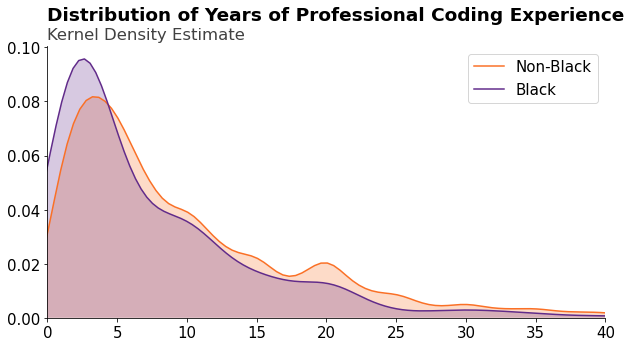

In [42]:
plt.rcParams.update({"font.size": 15})
plt.figure(figsize=(10,5))
ax = sns.kdeplot(X.loc[X["Ethnicity_Black_or_of_African_descent"] == 0]["YearsCodePro"], shade=True, color=colors[0])
ax2 = sns.kdeplot(X.loc[X["Ethnicity_Black_or_of_African_descent"] == 1]["YearsCodePro"], shade=True, color=colors[-1])
plt.text(x=0, y=0.11, s="Distribution of Years of Professional Coding Experience", fontsize=18.5, fontweight='semibold', color='black')
plt.text(x=0, y=0.103, s='Kernel Density Estimate', fontsize=16.5, color='#414141')
plt.legend(["Non-Black", "Black"])
sns.despine()
plt.xlim(0, 40)
plt.savefig('../images/progression_experience_kde.png', format='png', dpi=200)
plt.show()

In [43]:
color_scale = alt.Scale(
    domain=["Non-Black", "Black"],
    range=[colors[0], colors[-1]]
)

points = alt.Chart().mark_bar(size=50, cornerRadiusTopLeft=8, cornerRadiusTopRight=8, clip=True).encode(
    x=alt.X("labels", 
        axis=alt.Axis(title=None, labels=False, tickSize=0), 
        sort=labels
       ),
    y=alt.Y("data", 
            axis=alt.Axis(format=".1f", title=None, tickCount=4, tickSize=0, labelFlush=False, labelFontSize=15),
            scale=alt.Scale(
                domain=(0, 12)
            )
    ),
    color=alt.Color("labels", 
                    scale=color_scale,
                    legend=alt.Legend(title=None, orient="bottom", labelFontSize=15))
).properties(
    width=175,
    height=300
)

text = alt.Chart().mark_text(
    align='center',
    angle=0,
    baseline='middle',
    dx=-0,
    dy=-20,
    fontSize=15
).encode(
    text=alt.Text("data", format=".1f"),
    x=alt.X("labels", 
            sort=labels),
    y="data",
    color=alt.Color("labels", 
                    scale=color_scale)
)

chart = alt.layer(points, text, data=experience).facet(
    column=alt.Column("agg", title=None, header=alt.Header(labelOrient='bottom', labelFontSize=15)),
    title={
        "text": "Years of Professional Coding Experience", 
        "subtitle": "Mean and Median",
        "subtitleColor": "gray",
        "dy": 0
    },
    spacing=10
).configure_view(
    strokeWidth=0
).configure_title(
    anchor='start',
    offset=5,
    fontSize=20
).configure_axis(
    domain=False
)

chart.save("../images/progression_experience_agg.png", method="selenium", webdriver="chrome", scale_factor=3.0)

chart

alt.FacetChart(...)

In [45]:
points = alt.Chart().mark_bar(size=55, cornerRadiusTopLeft=8, cornerRadiusTopRight=8, clip=True).encode(
    x=alt.X("YearsCodePro",
            axis=alt.Axis(title=None, labelFontSize=15),
            scale=alt.Scale(
                domain=(0, 40)
            ),
           bin=alt.Bin(extent=[0, 40], step=5)),
    y=alt.Y("mean(Ethnicity_Black_or_of_African_descent)",
            axis=alt.Axis(format=".1%", title=None, tickCount=4, tickSize=0, labelFlush=False, labelFontSize=15),
            scale=alt.Scale(
                domain=(0, 0.04)
            )
           ),
    color=alt.Color("mean(Ethnicity_Black_or_of_African_descent)", 
                    scale=alt.Scale(scheme="inferno", domain=[0, 0.05]),
                    legend=None)
)

text = alt.Chart().mark_text(
    align='left',
    baseline='middle',
    dx=-15,
    dy=-15,
    fontSize=15
).encode(
    text=alt.Text("mean(Ethnicity_Black_or_of_African_descent)", format=".1%"),
    x=alt.X("YearsCodePro",
           bin=alt.Bin(extent=[0, 40], step=5)),
    y=alt.Y("mean(Ethnicity_Black_or_of_African_descent)"),
)

chart = alt.layer(points, text, data=data.groupby("YearsCodePro").mean()["Ethnicity_Black_or_of_African_descent"].reset_index()).properties(
    width=500,
    height=300,
    title={
        "text": "Representation by Years of Experience", 
        "subtitle": "% Black, 5-Year Bins",
        "subtitleColor": "gray"
    }
).configure_view(
    strokeWidth=0
).configure_title(
    anchor='start',
    offset=5,
    fontSize=20
).configure_axis(
    domain=False
)

chart.save("../images/progression_representation_experience.png", method="selenium", webdriver="chrome", scale_factor=3.0)

chart

alt.LayerChart(...)

In [113]:
color_scale = alt.Scale(
    domain=labels,
    range=colors
)

points = alt.Chart().mark_bar(size=180, cornerRadiusBottomRight=18, cornerRadiusTopRight=18, clip=True, color="#612b8a").encode(
    x=alt.X("data", 
            axis=alt.Axis(format=".1%", title=None, tickCount=5, tickSize=0, labelFlush=False, labelFontSize=15),
    ),
    y=alt.Y("labels", 
            axis=alt.Axis(title=None, labelFontSize=15), sort="-x"
           ),
    color=alt.Color("labels", 
                    scale=color_scale,
                    legend=None)
)

text = alt.Chart().mark_text(
    align='left',
    baseline='middle',
    dx=10,
    dy=0,
    fontSize=15
).encode(
    text=alt.Text("data", format=".1%"),
    x="data",
    y=alt.Y("labels", sort="-x"),
)

chart = alt.layer(points, text, data=representation["Leader"]).properties(
    width=600,
    height=500,
    title={
        "text": "Engineering Managers and Executives By Race", 
        "subtitle": "% of Software Developers",
        "subtitleColor": "gray"
    }
).configure_view(
    strokeWidth=0
).configure_title(
    anchor='start',
    offset=5,
    fontSize=20
).configure_axis(
    domain=False
)

chart.save("../images/progression_leaders.png", method="selenium", webdriver="chrome", scale_factor=3.0)

chart

alt.LayerChart(...)

Note: Due to some unforeseen stochasitcity in the model fitting process, the results for the leadership score quintiles can differ somewhat between various runs and may not match the exact numbers used in the final presentation. The broad conclusion remains unchanged, however.

In [162]:
color_scale = alt.Scale(
    domain=labels,
    range=colors
)

points = alt.Chart().mark_bar(size=35, cornerRadiusTopLeft=8, cornerRadiusTopRight=8, clip=True).encode(
    x=alt.X("labels", 
        axis=alt.Axis(title=None, labels=False, tickSize=0), 
        sort=labels
       ),
    y=alt.Y("data", 
            axis=alt.Axis(format=".1%", title=None, tickCount=4, tickSize=0, labelFlush=False, labelFontSize=15),
    ),
    color=alt.Color("labels", 
                    scale=color_scale,
                    legend=alt.Legend(title=None, orient="bottom", labelFontSize=15))
).properties(
    width=100,
    height=300
)

text = alt.Chart().mark_text(
    align='center',
    baseline='middle',
    dx=0,
    dy=-20,
    fontSize=15
).encode(
    text=alt.Text("data", format=".1%"),
    x=alt.X("labels", 
            sort=labels),
    y="data",
    color=alt.Color("labels", 
                    scale=color_scale)
)

chart = alt.layer(points, text, data=results_q_plot).facet(
    column=alt.Column("quantile", title=None, header=alt.Header(labelOrient='bottom', labelFontSize=15)),
    title={
        "text": "Engineering Managers or Executives by Leadership Score Quintile", 
        "subtitle": "% of Software Developers",
        "subtitleColor": "gray",
    },
    spacing=10
).configure_view(
    strokeWidth=0
).configure_title(
    anchor='start',
    offset=5,
    fontSize=20
).configure_axis(
    domain=False
)

chart.save("../images/progression_leaders_quintile.png", method="selenium", webdriver="chrome", scale_factor=3.0)

chart

alt.FacetChart(...)